# Time Series Sales Forecasting

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data Wrangling

In [2]:
train=pd.read_csv("Dataset/train.csv", parse_dates =['date'])
train.shape

(3000888, 6)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
# check for duplicates

train.duplicated().any()

False

In [5]:
# check for missing values

train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Missing Dates

In [6]:
# Min and max dates (range of dates)
data_train_start = train.date.min()
data_train_end = train.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_train_start,end=data_train_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(train['date'])

print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [7]:
store_nbr = train['store_nbr'].unique()

print(f'Unique stores in the train data are {store_nbr.size}')
store_nbr

Unique stores in the train data are 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [8]:
families = train['family'].unique()

print(f'Unique families in the train data are {families.size}')
families

Unique families in the train data are 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [9]:
missing_data_points = product(missing_dates, store_nbr, families)

new_data = pd.DataFrame(data=missing_data_points, columns=['date', 'store_nbr', 'family'])
new_data.tail()

,date,store_nbr,family
7123,2016-12-25,9,POULTRY
7124,2016-12-25,9,PREPARED FOODS
7125,2016-12-25,9,PRODUCE
7126,2016-12-25,9,SCHOOL AND OFFICE SUPPLIES
7127,2016-12-25,9,SEAFOOD


In [10]:
train = pd.concat([train, new_data],axis=0)
train.set_index('date', inplace=True)
train.tail()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2016-12-25,NaN,9,POULTRY,NaN,NaN
2016-12-25,NaN,9,PREPARED FOODS,NaN,NaN
2016-12-25,NaN,9,PRODUCE,NaN,NaN
2016-12-25,NaN,9,SCHOOL AND OFFICE SUPPLIES,NaN,NaN
2016-12-25,NaN,9,SEAFOOD,NaN,NaN


In [11]:
missing_dates = set(date_range) - set(train.index.unique())

print("Missing dates:", missing_dates)

Missing dates: set()


In [12]:
# drop 'id' column
train.drop(columns=['id'], inplace=True)

In [13]:
train.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [14]:
train['sales'] = train['sales'].fillna(0)
train['onpromotion'] = train['onpromotion'].fillna(0)

In [15]:
train.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [16]:
train.sort_index(inplace=True)
train.tail()

,store_nbr,family,sales,onpromotion
date,,,,
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0
2017-08-15,26,BOOKS,0.000,0.0
2017-08-15,1,BABY CARE,0.000,0.0


### Downsampling

Resampling to a lower frequency (downsampling) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. It is also known as "aggregation" or "reduction," and is a data transformation technique used to reduce the granularity of data by reducing the number of data points in a dataset. 

It involves converting high-frequency or fine-grained data into lower-frequency or coarser-grained data. The main purpose of downsampling is to make data more manageable, reduce computational and storage requirements, and make it easier to visualize and analyze data over longer time periods. It can also help in cases where the fine-grained data contains a lot of noise, and reducing the data points can reveal underlying trends and patterns.

In [17]:
train_downsampled = train.reset_index()
train_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 114.7+ MB


In [18]:
# resample data to daily frequency and compute the sum of sales for each week
cols = ['date', 'sales']

daily_sum_sales = train_downsampled[cols].set_index('date').resample('D').sum()
print(daily_sum_sales.shape)

(1688, 1)


In [19]:
fig = px.line(daily_sum_sales, x=daily_sum_sales.index, y='sales', title='Sum of Daily Sales')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

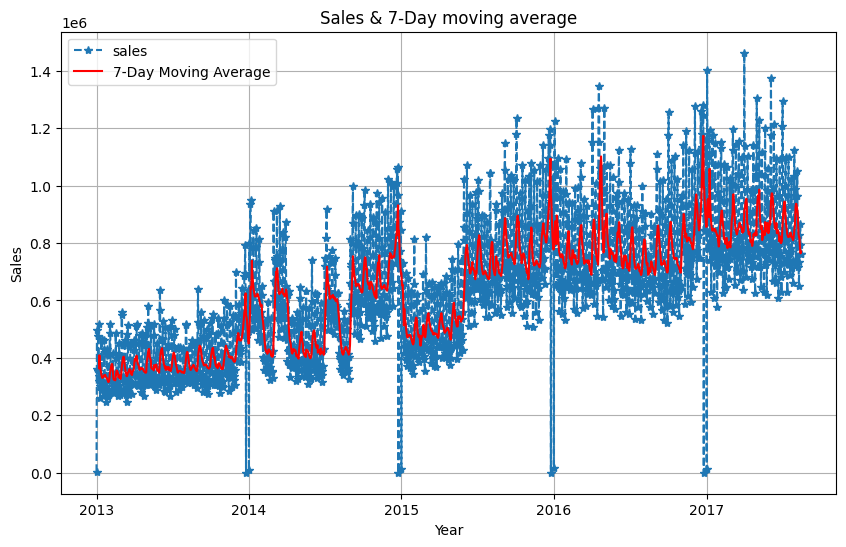

In [20]:
df_MA = daily_sum_sales.copy()
MA = df_MA['sales'].rolling(7).mean()

plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA.sales, '--', label='sales')
plt.plot(df_MA.index, MA, label='7-Day Moving Average', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales & 7-Day moving average')
plt.show()

## Stationarity Test

A time series has to have some statistical properties [to be able to stationary](https://python.plainenglish.io/time-series-analysis-mastering-the-concepts-of-stationarity-c9fc489893cf):

- **Constant mean**: There is no trend over time.
- **Constant variance, covariance**: The scale of the data doesn’t change and the relationship between observations is consistent.
- **No seasonality**: Statistical properties of seasonal data changes regularly. Therefore, there is a pattern of change in the mean.

- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary

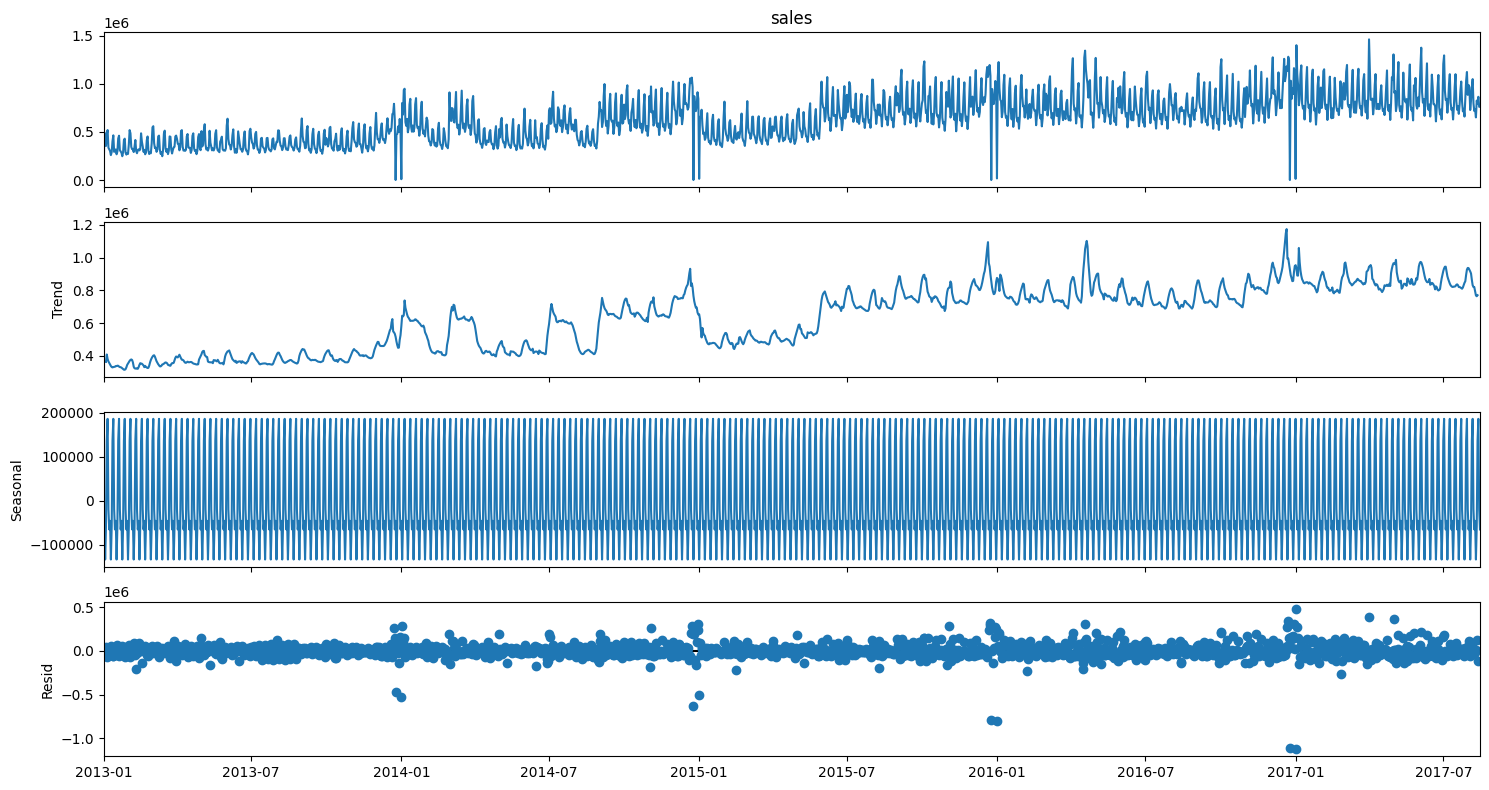

In [21]:
rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(daily_sum_sales['sales'], model='additive')
decompose_series.plot()
plt.show()

- Increasing trend and seasonality variations

In [22]:
adf_result = adfuller(daily_sum_sales['sales'])
print( f'ADF Statistic: {adf_result[ 0 ]}' )
print( f'p-value: {adf_result[ 1 ]}' )
print( f'No. of lags used: {adf_result[ 2 ]}' )
print( f'No. of observations used : {adf_result[ 3 ]}' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f'{k} : {v}' )
 if adf_result[1] < 0.05:
    print('Series is stationary')
else:
    print('Series is not stationary')

ADF Statistic: -2.571413630171701
p-value: 0.09905058352484208
No. of lags used: 22
No. of observations used : 1665
Critical Values:
1% : -3.434283579780684
5% : -2.863277451883613
10% : -2.5676949772294817
Series is not stationary


- At the 1% and 5% significance levels, the evidence is not strong enough to reject the null hypothesis. Thus, the data is considered non-stationary at these levels.

- At the 10% significance level, there is some evidence to reject the null hypothesis, suggesting the data might be stationary.

### Differencing

- Differencing is a technique used to remove trends or seasonality from a time series data. It involves subtracting the previous value from the current value to detect and remove patterns that vary over time.

In [23]:
# Convert time series to stationary by removing trend and seasonality

daily_sum_sales['shift'] = daily_sum_sales.sales.shift()
daily_sum_sales['shiftDiff'] = daily_sum_sales['sales'] - daily_sum_sales['shift']
daily_sum_sales.head()

,sales,shift,shiftDiff
date,,,
2013-01-01,2511.618999,NaN,NaN
2013-01-02,496092.417944,2511.618999,493580.798945
2013-01-03,361461.231124,496092.417944,-134631.186820
2013-01-04,354459.677093,361461.231124,-7001.554031
2013-01-05,477350.121229,354459.677093,122890.444136


In [24]:
adf_result = adfuller(daily_sum_sales['shiftDiff'].dropna())

# Print ADF test results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'{k}: {v}')

# Print stationarity status
if adf_result[1] < 0.05:
    print('Series is stationary')
else:
    print('Series is not stationary')

ADF Statistic: -11.311582910042983
p-value: 1.2352337993915324e-20
No. of lags used: 25
No. of observations used: 1661
Critical Values:
1%: -3.4342930672797065
5%: -2.8632816397229064
10%: -2.567697207194407
Series is stationary


### Autocorrelation Function (ACF):

Autocorrelation refers to the correlation between the past values in a time series. It measures the linear relationship between lagged values in the series. The ACF plot or correlogram is used to display the autocorrelation in a time series by lag. The correlation coefficient between -1 and 1 is displayed on the y-axis and the lags displayed on the x-axis. 

### Partial Autocorrelation Function (PACF):

PACF gives the partial correlation of a stationary series with its lagged values not accounted for by prior lagged observations. This gives an overview of the relationship between an observation in a series and observations in previous time steps while removing interfering observations. The PACF at a specific lag is the correlation that occurs after removing the effect of any correlations as a result of shorter lags. In contrast to ACF, it controls for other lags. 

The ACF and PACF plots are displayed as bar charts showing confidence intervals at 95% and 99% as horizontal lines across the bars. Any bar that crosses these intervals are deemed to be more significant and worth noting.

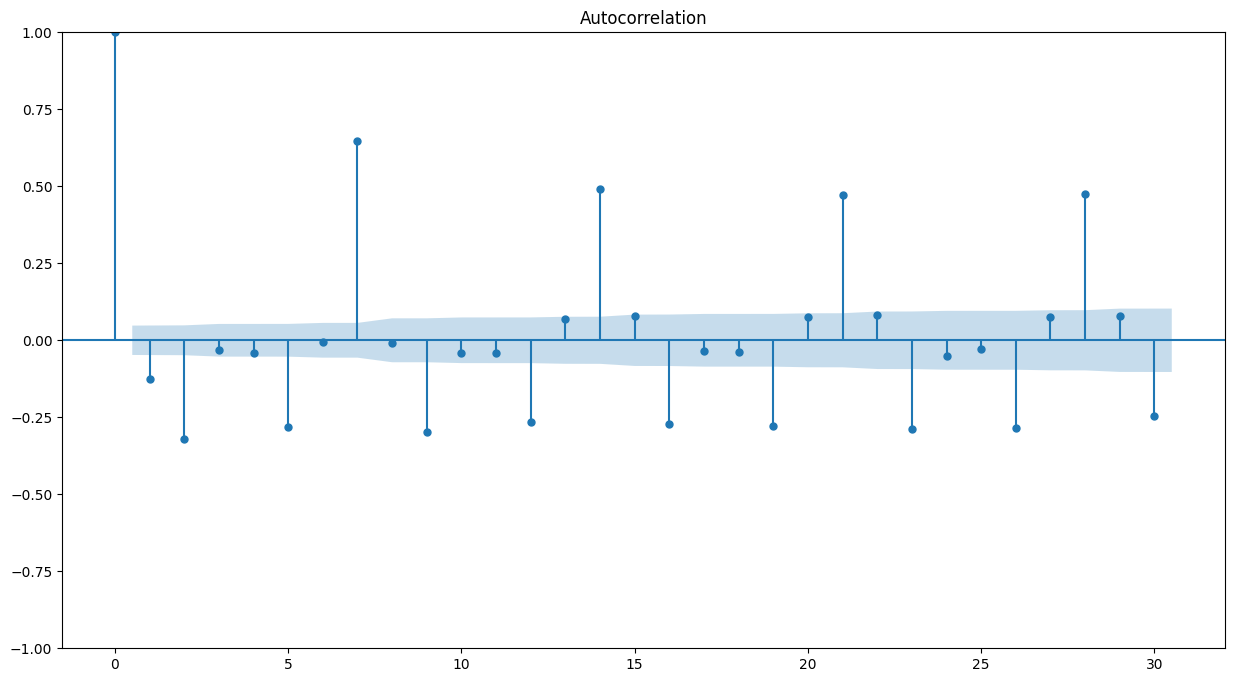

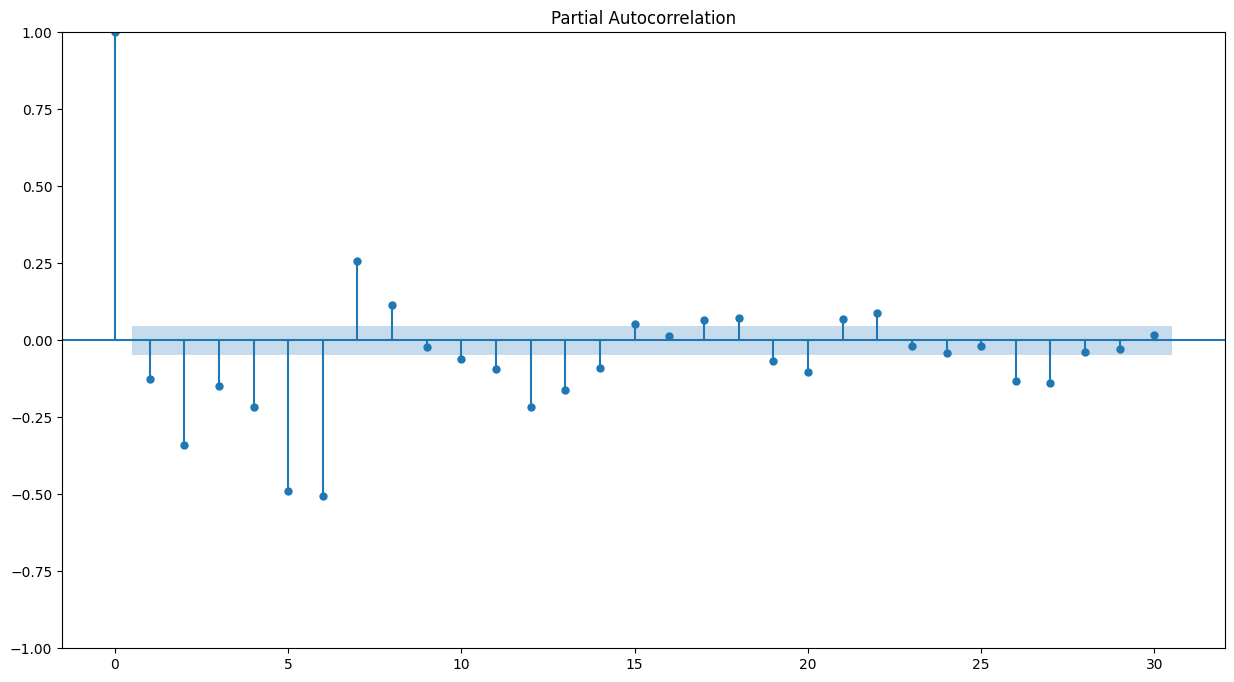

In [25]:
acf = plot_acf(daily_sum_sales['shiftDiff'].dropna(), lags = 30)
pacf = plot_pacf(daily_sum_sales['shiftDiff'].dropna(), lags = 30)

In [26]:
# Specify the date to split the data
split_date = '2017-01-01'

# Create train and test splits based on the index order
training_set = daily_sum_sales.loc[daily_sum_sales.index < split_date]
eval_set = daily_sum_sales.loc[daily_sum_sales.index >= split_date]

training_set.shape, eval_set.shape

((1461, 3), (227, 3))

## Modeling

In [27]:
#AR
AR_model = ARIMA(training_set['shiftDiff'].dropna(), order=( 7 , 0 , 0 ))
AR_model_results = AR_model.fit()
AR_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              shiftDiff   No. Observations:                 1460
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -18971.085
Date:                Mon, 17 Jun 2024   AIC                          37960.170
Time:                        09:50:32   BIC                          38007.746
Sample:                    01-02-2013   HQIC                         37977.918
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        757.8775    862.696      0.878      0.380    -932.975    2448.730
ar.L1         -0.4501      0.010    -43.838      0.000      -0.470      -0.430
ar.L2         -0.5050      0.015    -32.692      0.000      -0.535      -0.475
ar.L3         -0.4344      0.021    -20.206      0.000      -0.477      -0.392
ar.L4         -0.4216      0.021    -20.520      0.000      -0.462      -0.381
ar.L5         -0.4651      0.021    -22.510      0.000      -0.506      -0.425
ar.L6         -0.3355      0.017    -19.276      0.000      -0.370      -0.301
ar.L7          0.3010      0.014     21.700      0.000       0.274       0.328
sigma2      1.124e+10      0.002    6.6e+12      0.000    1.12e+10    1.12e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):             43882.20
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               3.26   Skew:                            -1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+28. Standard errors may be unstable.
"""

In [30]:
# Make predictions using the AR model on train and evaluation data

AR_pred = AR_model_results.predict (start = len(training_set['shiftDiff']),
                           end = len(training_set['shiftDiff']) + len(eval_set['shiftDiff']) - 1,
                           dynamic = False
                           )

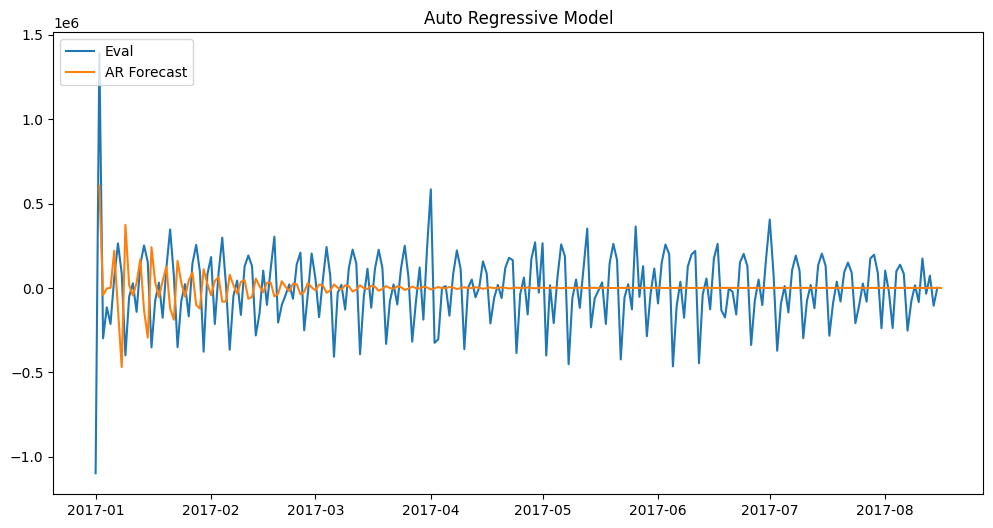

In [31]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['shiftDiff'], label = 'Eval')
plt.plot (AR_pred, label = 'AR Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Model')
plt.show()

In [32]:
mse = mean_squared_error(eval_set['shiftDiff'], AR_pred)
rmse = np.sqrt(mean_squared_error(eval_set['shiftDiff'], AR_pred)).round(2)
mae = mean_absolute_error(eval_set['shiftDiff'], AR_pred).round(2)

# Create results DataFrame
results_1 = pd.DataFrame([['AR', mse, rmse, mae]], columns=['Model', 'MSE', 'RMSE', 'MAE'])

results_1

,Model,MSE,RMSE,MAE
0,AR,6.527410e+10,255487.96,176835.9


In [33]:
# We use pmdarima to determine the best parameter for our ARIMA model.

stepwise_fit = auto_arima(training_set['shiftDiff'].dropna(), trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38634.562, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39190.075, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39174.027, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38981.658, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39188.106, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38668.017, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=38671.450, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=38650.185, Time=0.87 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38332.484, Time=1.80 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38701.011, Time=0.39 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=38541.028, Time=1.05 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=38674.541, Time=1.06 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=38317.411, Time=2.62 sec
 ARIMA(4,0,4)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(5, 0, 2)   Log Likelihood              -19034.996
Date:                Mon, 17 Jun 2024   AIC                          38085.992
Time:                        10:08:20   BIC                          38128.282
Sample:                    01-02-2013   HQIC                         38101.768
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1829      0.021      8.542      0.000       0.141       0.225
ar.L2         -0.7341      0.019    -38.589      0.000      -0.771      -0.697
ar.L3         -0.2588      0.023    -11.470      0.000      -0.303      -0.215
ar.L4         -0.3541      0.019    -18.344      0.000      -0.392      -0.316
ar.L5         -0.4961      0.019    -26.029      0.000      -0.534      -0.459
ma.L1         -0.7459      0.023    -32.861      0.000      -0.790      -0.701
ma.L2          0.5728      0.020     28.553      0.000       0.533       0.612
sigma2      1.226e+10   3.36e-12   3.65e+21      0.000    1.23e+10    1.23e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             33274.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.71   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.1e+36. Standard errors may be unstable.
"""

In [34]:
model_2 = ARIMA(training_set['shiftDiff'].dropna(), order=(5,0,2))
model_2_fit = model_2.fit()
model_2_fit.summary()

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              shiftDiff   No. Observations:                 1460
Model:                 ARIMA(5, 0, 2)   Log Likelihood              -19034.956
Date:                Mon, 17 Jun 2024   AIC                          38087.912
Time:                        10:19:06   BIC                          38135.488
Sample:                    01-02-2013   HQIC                         38105.659
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        757.8775    953.165      0.795      0.427   -1110.291    2626.046
ar.L1          0.1828      0.022      8.470      0.000       0.140       0.225
ar.L2         -0.7340      0.019    -38.594      0.000      -0.771      -0.697
ar.L3         -0.2589      0.023    -11.460      0.000      -0.303      -0.215
ar.L4         -0.3540      0.019    -18.288      0.000      -0.392      -0.316
ar.L5         -0.4962      0.019    -26.111      0.000      -0.533      -0.459
ma.L1         -0.7457      0.023    -32.342      0.000      -0.791      -0.701
ma.L2          0.5727      0.021     27.911      0.000       0.532       0.613
sigma2      1.226e+10      0.001    8.3e+12      0.000    1.23e+10    1.23e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             33258.82
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.71   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+27. Standard errors may be unstable.
"""

In [35]:
# Make predictions on the test data

ARIMA_pred = model_2_fit.predict(start=len(training_set['shiftDiff'].dropna()),
                                 end=len(training_set['shiftDiff'].dropna()) + len(eval_set['shiftDiff']) - 1,
                                 typ="levels")

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



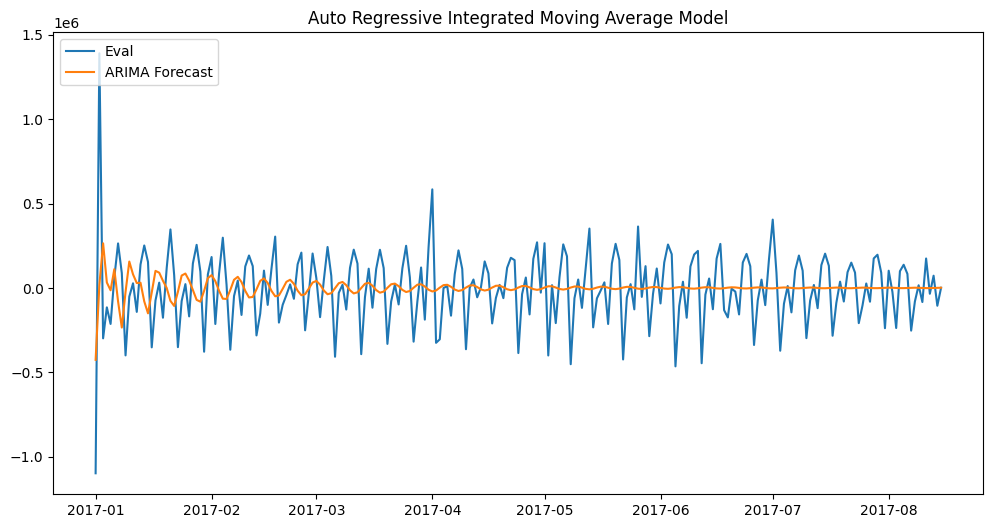

In [36]:
# plot the evaluation and model predictions

plt.figure(figsize = (12,6))
plt.plot(eval_set['shiftDiff'], label = 'Eval')
plt.plot (ARIMA_pred, label = 'ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Integrated Moving Average Model')
plt.show()

In [38]:
mse = mean_squared_error(eval_set['shiftDiff'], ARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['shiftDiff'], ARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['shiftDiff'], ARIMA_pred).round(2)


model_results = pd.DataFrame([['ARIMA', mse, rmse, mae]], columns = ['Model', 'MSE', 'RMSE', 'MAE'])
results_2 = pd.concat([results_1, model_results], ignore_index=True)
results_2

,Model,MSE,RMSE,MAE
0,AR,6.527410e+10,255487.96,176835.90
1,ARIMA,5.044492e+10,224599.48,171405.65


In [40]:
model_3 = SARIMAX(training_set['shiftDiff'].dropna(), order=(5,0,2), seasonal_order=(5,0,2,7)) 
model_3_fit = model_3.fit()
model_3_fit.summary()

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         shiftDiff   No. Observations:                 1460
Model:             SARIMAX(5, 0, 2)x(5, 0, 2, 7)   Log Likelihood              -18846.350
Date:                           Mon, 17 Jun 2024   AIC                          37722.700
Time:                                   10:25:00   BIC                          37801.993
Sample:                               01-02-2013   HQIC                         37752.279
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5220      0.213     -2.452      0.014      -0.939      -0.105
ar.L2          0.4362      0.093      4.669      0.000       0.253       0.619
ar.L3          0.1444      0.043      3.346      0.001       0.060       0.229
ar.L4          0.0673      0.045      1.502      0.133      -0.021       0.155
ar.L5          0.0218      0.039      0.558      0.577      -0.055       0.098
ma.L1         -0.0546      0.215     -0.254      0.799      -0.476       0.366
ma.L2         -0.8848      0.208     -4.244      0.000      -1.293      -0.476
ar.S.L7        0.2779      0.038      7.254      0.000       0.203       0.353
ar.S.L14       0.9919      0.049     20.442      0.000       0.897       1.087
ar.S.L21      -0.2619      0.056     -4.663      0.000      -0.372      -0.152
ar.S.L28      -0.0834      0.042     -2.008      0.045      -0.165      -0.002
ar.S.L35       0.0739      0.055      1.353      0.176      -0.033       0.181
ma.S.L7        0.0109      0.028      0.384      0.701      -0.045       0.067
ma.S.L14      -0.9424      0.024    -39.922      0.000      -0.989      -0.896
sigma2      1.226e+10   2.95e-11   4.16e+20      0.000    1.23e+10    1.23e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            111453.87
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.09e+36. Standard errors may be unstable.
"""

In [41]:
SARIMA_pred = model_3_fit.predict(start=len(training_set['shiftDiff']),
                                 end=len(training_set['shiftDiff']) + len(eval_set['shiftDiff']) - 1,
                                 typ="levels")

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



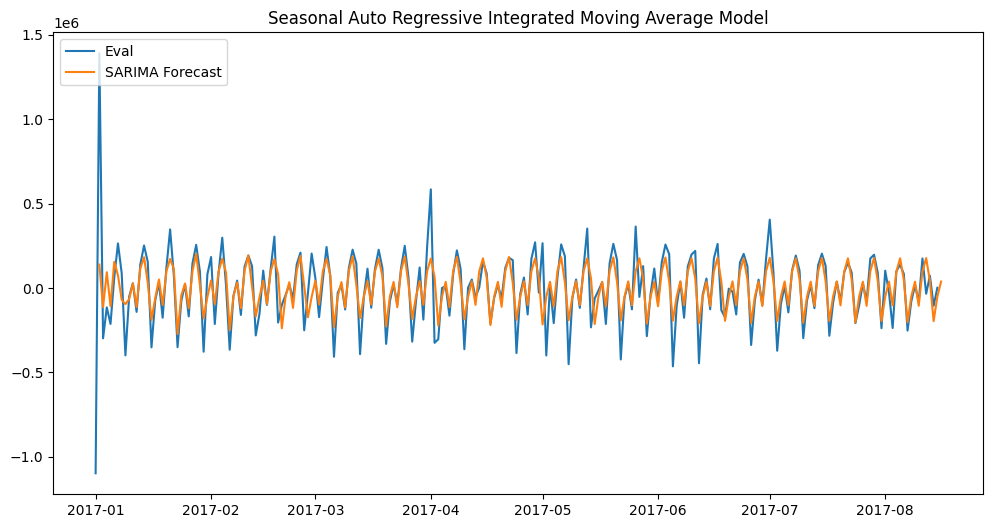

In [42]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['shiftDiff'], label = 'Eval')
plt.plot (SARIMA_pred, label = 'SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

In [43]:
mse = mean_squared_error(eval_set['shiftDiff'], SARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['shiftDiff'], SARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['shiftDiff'], SARIMA_pred).round(2)


model_results = pd.DataFrame([['SARIMA', mse, rmse, mae]], columns = ['Model', 'MSE', 'RMSE', 'MAE'])
results_3 = pd.concat([results_2, model_results], ignore_index=True)
results_3

,Model,MSE,RMSE,MAE
0,AR,6.527410e+10,255487.96,176835.90
1,ARIMA,5.044492e+10,224599.48,171405.65
2,SARIMA,6.156164e+10,248116.19,193851.84


In [ ]:
# Predictions

# future_dates = pd.DataFrame(pd.date_range(start='2017-08-16', end='2017-08-31', freq='D'), columns=['dates'])
# future_dates.set_index('dates', inplace=True)
# future_dates.head()

##model_2_fit.predict(start=future_dates.index[0], end=future_dates.index[-1])